# Quantum Simulation via Superconducting Quantum Hardware

In [1]:
from qiskit import *
from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit import IBMQ
IBMQ.save_account("26595118309e0ea848015d3f7458b040ec723a9c11afd2d777038533a5a2b8079312af1e3713e370053f85bf7dd5d77f72993b0f04c2cd561e4c31f5a40c910c")
IBMQ.load_account()

configrc.store_credentials:WARNING:2021-04-11 21:55:04,194: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_santiago')
properties = backend.properties()

The Hamiltonian we consider 

$H=V\sum_{\left\langle i,j\right\rangle }Z_{i}Z_{j}+\Omega\sum_{i}X_{i}+h\sum_{i}Z_{i}$

In [4]:
def h_Z(qc,h,dt):
    for i in range(5):
        qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt):
    for i in range(5):
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt):
    #for i in range(5):
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)
    

In [5]:
def Trotter_circuit_5_site(h,Omega,V,T,n):
    Trotter_circuits = []
    dt=T/n
    for i in range(n):
        Trotter_circuit = QuantumCircuit(5)
        Trotter_circuit.x(1)
        Trotter_circuit.x(3)
        #Trotter_circuit.x(4)
        Trotter_circuit.barrier()
        for k in range(i):
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        Trotter_circuits.append(Trotter_circuit)
    return Trotter_circuits
    
    

In [6]:
Omega = 0.2*2
h = 2*2
V = 1*2
T = 15 # Total time 
n = 75
Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

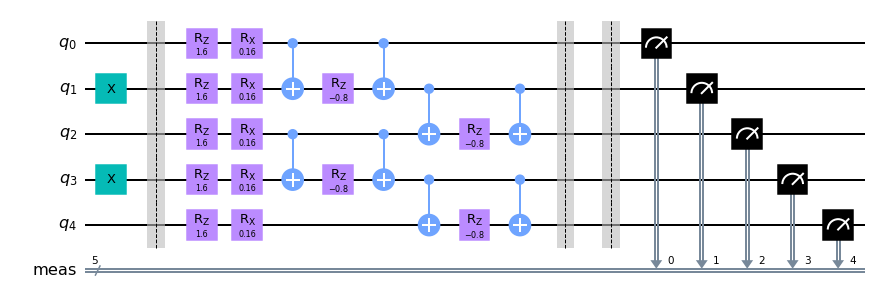

In [7]:
Trotter_circuit[1].draw(output = "mpl")

In [8]:
qr = QuantumRegister(5)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')



In [9]:
shots = 8192
il = [0,1,2,3,4]
Trotter_circuit_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), shots=shots, initial_layout=il)

Trotter_result = execute(Trotter_circuit, backend, shots=shots, initial_layout=il)

Trotter_mit  = execute(meas_calibs, backend, shots=shots, initial_layout=il)

In [10]:
#for job in all_jobs:
job_monitor(Trotter_result)
    #try:
        #if job.error_message() is not None:
            #print(job.error_message())
    #except:
        #pass

Job Status: job has successfully run


In [11]:
result_counts = Trotter_mit.result()#.get_counts(25)

results = Trotter_result.result()

In [12]:
cal_results = Trotter_mit.result()

In [13]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[9.01367188e-01 2.94189453e-02 3.07617188e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.19726562e-02 9.32983398e-01 7.32421875e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.91748047e-02 2.44140625e-04 9.23217773e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.12109375e-01
  7.32421875e-04 3.19824219e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.22070312e-04
  8.95263672e-01 2.86865234e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.25732422e-02
  2.01416016e-02 8.92700195e-01]]


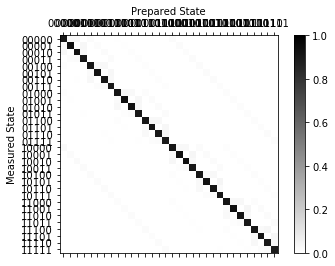

In [14]:
meas_fitter.plot_calibration()

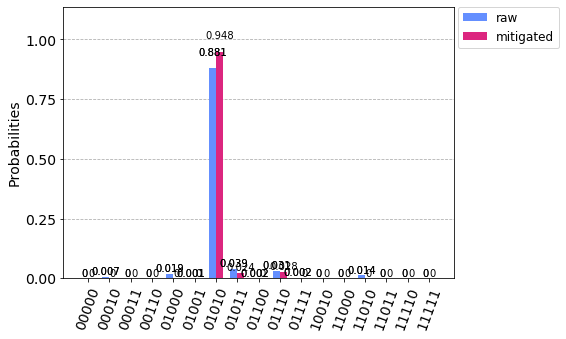

In [15]:
from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np

Result_nomit = results.get_counts(0) 
mitigated_counts = meas_fitter.filter.apply(results).get_counts(0)
plot_histogram([Result_nomit, mitigated_counts], legend=['raw', 'mitigated'])

In [16]:
tot=np.zeros(5)

for i in range(2**5):
    n=2**5
    if i in Result_nomit.int_outcomes():
        a=bin(n+i)[3:]
        c= ' '
        tot+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_nomit.int_outcomes()[i]
tot/8192

array([-0.96875   ,  0.98291016, -0.9284668 ,  0.95361328, -0.91040039])

In [17]:
Sz_nomit = []
Sz_mit = []
for i in range(75):
    tot_nomit=np.zeros(5)
    tot_mit=np.zeros(5)
    Result_nomit = results.get_counts(i) 
    mitigated_counts = meas_fitter.filter.apply(results).get_counts(i)
    for j in range(2**5):
        n=2**5
        if j in Result_nomit.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_nomit+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_nomit.int_outcomes()[j] 
        if j in mitigated_counts.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_mit+=(2*np.array(c.join(a).split()).astype(int)-1)*mitigated_counts.int_outcomes()[j]
    Sz_nomit.append(tot_nomit/8192)
    Sz_mit.append(tot_mit/8192)
Sz_nomit=np.array(Sz_nomit)
Sz_mit=np.array(Sz_mit)

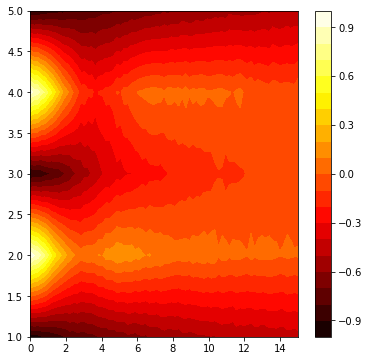

In [18]:
t=np.linspace(0,15,75)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_nomit), 20, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)
#plt.xscale('log')
#ax.set_xscale('log')
#ax.set_xlim(1e6,1e10)
plt.show()


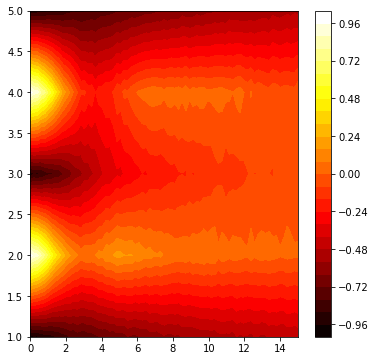

In [19]:
t=np.linspace(0,15,75)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_mit), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)
#plt.xscale('log')
#ax.set_xscale('log')
#ax.set_xlim(1e6,1e10)
plt.show()

In [20]:
result_sim=Trotter_circuit_sim.result()

In [21]:

Sz_sim = []
for i in range(75):
    tot_sim=np.zeros(5)
    Result_sim = result_sim.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim.int_outcomes()[j] 
    Sz_sim.append(tot_sim/8192)
Sz_sim=np.array(Sz_sim)

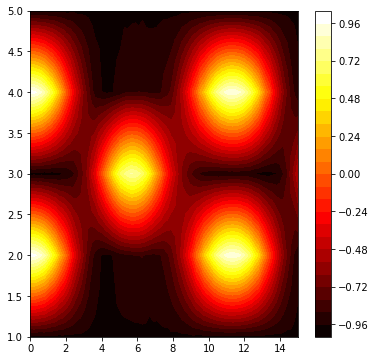

In [22]:
t=np.linspace(0,T,75)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

plt.show()

# Classical simulation

In [45]:
import scipy.linalg as la

def flip(n,i,L): 
    # Flip the i site spin in n-state with system size L
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))


def binaryToDecimal(binary): 
    # change the binary number into decimal number
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

def spin_x(i,L):
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

def spin_y(i,L):
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

def spin_z(i,L):
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[2:][::-1][i])-1
    return Z



In [46]:
L=5

Omega=0.2*2
h=2*2
V=1*2

H0=0

for i in range(L):
    H0=H0+Omega*spin_x(i,L)+h*spin_z(i,L)


V0=0
for i in range(L-1):
    n_f=spin_z((i)%L,L)
    n_b=spin_z((i+1)%L,L)
    V0=V0+V*np.dot(n_f,n_b)


H=H0+V0

In [47]:
M=H
vals, vecs = la.eigh(M)

inds=np.argsort(vals)
e=vals[inds]
v=vecs[:,inds]

In [48]:
binaryToDecimal(1010)

10

In [49]:
Nt=75-1
T=15
dt=T/Nt

A=np.eye(len(e))*e
U=np.dot(v,np.dot(np.exp(-1j*A*dt)*np.eye(len(e)),np.conj(np.transpose(v))))

f = 10

wavefunc=np.zeros((len(e),Nt+1),dtype=complex)
n=np.zeros(len(e),dtype=complex)
n[f]=1
wavefunc[:,0]=n
for i in range(Nt):
    wavefunc[:,i+1]=np.dot(U,wavefunc[:,i])


In [50]:
def Zi_t_p(tf,dt,f,i):
  
  
    Nt=tf/dt
    Nt=int(Nt)

    Zt=spin_z(i,L)
    Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),np.dot(Zt,wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=np.stack(Zt1,axis=0)
    return Zt1

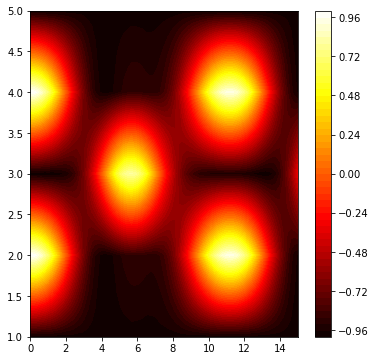

In [51]:
Zi=np.zeros((L,75))
for i in range(L):
    Zi[i,:]=np.real(Zi_t_p(T,dt,f,i))
t=np.linspace(0,T,75)
l=np.linspace(1,L,L)
T, LL = np.meshgrid(t, l)
#cmap = mpl.cm.hot
#norm = mpl.colors.Normalize(vmin=-1, vmax=1)
fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(T, LL, Zi, 50, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)
#plt.xscale('log')
#ax.set_xscale('log')
#ax.set_xlim(0,1e10)
plt.show()